<a href="https://colab.research.google.com/github/mshilpaa/machine_learning/blob/master/Mask_Depth_Prediction/dice_ssim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%%file  requirements.txt 

kornia
memory_profiler
torchsummary
git+https://github.com/albu/albumentations

Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1gfz7ob2
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1gfz7ob2
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=4fbb16173151e541f86f443a3aebbc3c2debe45ec8f9705921dda30e602002ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-tv6cva5h/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations


In [4]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-pe2ky1bd
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-pe2ky1bd
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=89fe6de94b5bfbd3ad19c138adf7e1a4f402f8cd5595bb4288b531ba6aa53452
  Stored in directory: /tmp/pip-ephem-wheel-cache-w4o5yo7e/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
%load_ext tensorboard
%load_ext memory_profiler

In [0]:
import os

import torch
import numpy as np
from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import sys
from torchsummary import summary

In [7]:
%%file customdata_loading.py

import torch
import numpy as np
from PIL import Image
import os
import torch
# from skimage import io
import numpy as np
from torch.utils.data import Dataset
import random
from matplotlib.image import imread
import matplotlib.pyplot as plt

def unzip_files(File = '/content/gdrive/My Drive/Mask_Rcnn/Dataset'):
  
  from zipfile import ZipFile 
  

  for i in os.listdir(File):
    filename = f'{File}/{i}'
    print(filename)
  # opening the zip file in READ mode 
    with ZipFile(filename, 'r') as zip_file: 
      
        # extracting all the files 
        print('Extracting all the files now...') 
        zip_file.extractall() 
        print('Done!')

def get_data(label_file='/content/gdrive/My Drive/Mask_Rcnn/labels.txt',length=None):
    fg_bg = []
    bg = []
    mask = []
    depth_img = []
    if length == None:
      labels = (open(label_file,'r')).readlines()
    else:
      labels = (open(label_file,'r')).readlines()[:length]
    for label in labels:
      a  = label.split('\t')
      bg.append(f'/content/gdrive/My Drive/Mask_Rcnn/{a[0]}')
      fg_bg.append(f'/content/{a[2]}')         
      mask.append(f'/content/{a[3]}')
      depth = a[4].split('\n')[0]
      depth_img.append(f'/content/{depth}')
    dataset =  list(zip(bg,fg_bg,mask,depth_img))
    random.shuffle(dataset)
    train_split = 70
    train_len = len(dataset)*train_split//100
    train = dataset[:train_len]
    test = dataset[train_len:]
    return train,test

      
class CustomDataset(Dataset):
    def __init__(self, data, transform=None,mask_transform=None,depth_transform=None):
        self.transform = transform
        self.bg,self.fg_bg,self.mask,self.depth_img = zip(*data)
        # self.mask_transform = A.Compose([ A.Normalize(mean=(0.04608837, 0.04608837, 0.04608837)	, 
        #                                                 std=(0.20544916, 0.20544916, 0.20544916)),
        #                                    AP.ToTensor()])
        # self.depth_transform = A.Compose([ A.Normalize(mean=(0.50911522, 0.50911522, 0.50911522)	, 
        #                                                 std=(0.28174302, 0.28174302, 0.28174302)),
        #                                    AP.ToTensor()])

        self.mask_transform = mask_transform
        self.depth_transform = depth_transform

    def __len__(self):
        return len(self.fg_bg)

    def __getitem__(self, idx):
  
        # print(self.fg_bg[idx],'---',idx,'----')
        bg = np.asarray(Image.open(self.bg[idx]))
        fg_bg = np.asarray(Image.open(self.fg_bg[idx]))
        mask = np.asarray(Image.open(self.mask[idx]))
        depth = np.asarray(Image.open(self.depth_img[idx]))

        if self.mask_transform:
          img = mask
          # if(len(img.shape) ==2):         
          #       img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

          mask = self.mask_transform(image= img )['image']

        if self.depth_transform:
          img=depth
          # if(len(img.shape) ==2):         
          #       img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
          depth = self.depth_transform(image= img )['image']

        if self.transform:
            bg = self.transform(image=bg)['image']
            fg_bg = self.transform(image=fg_bg)['image']
        
        return bg,fg_bg,mask,depth

def form_data(unzip=False,length =None, train_transform =None,train_mask_transform=None, train_depth_transform=None,
              test_transform =None,test_mask_transform=None, test_depth_transform=None):
  if unzip == True:
    unzip_files()
  else:
    print('Files already downloaded')
  print('Forming the dataset')
  train, test = get_data(length=length)

  train_set = CustomDataset(train,transform=train_transform ,mask_transform=train_mask_transform, depth_transform=train_depth_transform)
  test_set = CustomDataset(test,transform=test_transform ,mask_transform=test_mask_transform, depth_transform=test_depth_transform)
  print('Done!')
  return train_set, test_set

Overwriting customdata_loading.py


In [8]:
%%file data_load.py

import torch
import torchvision



def load(train_set,test_set,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()


	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)
	testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)


	return  trainloader, testloader

Overwriting data_load.py


In [0]:
import customdata_loading 
import data_load

In [0]:
import albumentations as A
import albumentations.pytorch as AP
# from torch.utils.data import random_split
mean =  (0.65830478,0.61511271, 0.5740604 )
std = (0.24408717, 0.2542491, 0.26870159)
	
train_transform = A.Compose(
    [ 
    #  A.ToGray( p=1.0),
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1), 
     A.Cutout(num_holes=4, max_h_size=16,max_w_size = 16,p=1,fill_value=0.6*255), 
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])
            
test_transform = A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])


train_mask_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
    #  A.Normalize(mean=(0.04608837),std=(0.20544916)),
     AP.ToTensor()        
             ])

train_depth_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
    #  A.Normalize(mean=(0.50911522)	,std=(0.28174302)),
     AP.ToTensor()        
             ])

test_target_transform =  A.Compose(
    [ 
     A.Resize(64, 64, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])




In [11]:
train_set,test_set = customdata_loading.form_data(unzip=False,length = 80000,
                                                  train_transform=train_transform ,
                                                  train_mask_transform=train_mask_transform,
                                                  train_depth_transform=train_depth_transform, 
                                                  test_transform=test_transform ,
                                                  test_mask_transform=test_target_transform, 
                                                  test_depth_transform=test_target_transform)

Files already downloaded
Forming the dataset
Done!


In [12]:
print(len(train_set))
print(len(test_set))

56000
24000


In [0]:

trainloader,testloader = data_load.load(train_set,test_set,batch_size=128)

# Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Resnet_Block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Resnet_Block, self).__init__()
        # Input Block

        self.conv1 = nn.Sequential(
          
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
          
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
      )
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self,x):
      out = self.conv1(x)
      
      one = self.shortcut(x)
      # print(out.size(),x.size(),one.size())
      out += one
      return out

class Downsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Downsample, self).__init__()
        # Input Block
        
        self.conv1 = nn.Sequential(
          
          # nn.BatchNorm2d(in_channels),
          # nn.ReLU(),
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False,stride=2), 
          
          # nn.BatchNorm2d(out_channels),
          # nn.ReLU(),
          # nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
      )
        
        # self.shortcut = nn.Sequential(
        #     nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False,stride=2),
        # )

    def forward(self,x):
      out = self.conv1(x)
      
      # one = self.shortcut(x)
      # print('---',out.size(),x.size(),one.size())
      # out += one
      return out

class Upsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Upsample, self).__init__()
        # Input Block
        
        self.conv1 = nn.Sequential(
          
          # nn.BatchNorm2d(in_channels),
          # nn.ReLU(),
          nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2), padding=0, bias=False,stride=2), 
          
          # nn.BatchNorm2d(out_channels),
          # nn.ReLU(),
          # nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
      )
        
        # self.shortcut = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False,stride=2),
        # )

    def forward(self,x):
      out = self.conv1(x)
      
      # one = self.shortcut(x)
      # print('---',out.size(),x.size(),one.size())
      # out += one
      return out

def final_layer(in_channels,out_channels):
  return nn.Sequential(
          
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
          nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
  )       

class Unet_Resnet(nn.Module):
    def __init__(self):
        super(Unet_Resnet, self).__init__()
        # Input Block

        self.conv1 = nn.Conv2d(in_channels=6, out_channels=64, kernel_size=(3, 3), padding=1, bias=False)
      
       
        
        self.enc1 = Resnet_Block(64,64)
        self.enc2 = Resnet_Block(128,128)
        self.enc3 = Resnet_Block(128,128)
        self.enc4 = Resnet_Block(256,256)
        self.enc5 = Resnet_Block(256,256)

        self.enc1_down = Downsample(64,128)       
        self.enc2_down = Downsample(128,128)
        self.enc3_down = Downsample(128,256)
        self.enc4_down = Downsample(256,256)

        self.dec1_1 = final_layer(64,1)
        self.dec1 = Resnet_Block(128,64)
        self.dec2 = Resnet_Block(256,128)
        self.dec3 = Resnet_Block(256,128)
        self.dec4 = Resnet_Block(512,256)
        # self.dec5 = Resnet_Block(128,128)


        self.dec1_up = Upsample(128,64)       
        self.dec2_up = Upsample(128,128)
        self.dec3_up = Upsample(256,128)
        self.dec4_up = Upsample(256,256)


        self.Mdec1_1 = final_layer(64,1)
        self.Mdec1 = Resnet_Block(128,64)
        self.Mdec2 = Resnet_Block(256,128)
        self.Mdec3 = Resnet_Block(256,128)
        self.Mdec4 = Resnet_Block(512,256)
        # self.Mdec5 = Resnet_Block(128,128)


        self.Mdec1_up = Upsample(128,64)       
        self.Mdec2_up = Upsample(128,128)
        self.Mdec3_up = Upsample(256,128)
        self.Mdec4_up = Upsample(256,256)

        self.sigmoid = nn.LogSigmoid()
        self.relu = nn.ReLU()

    def forward(self,x):

      out1 = self.conv1(x)       # o/p 64x64x64
      # print('out1',out1.size())
      en1 = self.enc1(out1)       # 64x64x64
      # print('en1',en1.size())
      en1_1 = self.enc1_down(en1)   # 128x32x32
      # print('en1_1',en1_1.size())
      en2 = self.enc2(en1_1)       # 128x32x32
      # print('en2',en2.size())
      en2_1 = self.enc2_down(en2)  # 128x16x16
      # print('en2_1',en2_1.size())
      en3 = self.enc3(en2_1)       # 128x16x16
      # print('en3',en3.size())
      en3_1 = self.enc3_down(en3)  # 256x8x8
      # print('en3_1',en3_1.size())

      en4 = self.enc4(en3_1)       # 256x8x8
      # print('en4',en4.size())
      en4_1 = self.enc4_down(en4)  # 256x4x4
      # print('en4_1',en4_1.size())

      en5 = self.enc5(en4_1)       # 512x4x4
      # print('en5',en5.size())

# depth
      de4 = self.dec4_up(en5)     # 128x8x8
      # print('de4',de4.size())
      de4_1 = torch.cat((en4,de4 ),1)             # 256x8x8
      # print('de4_1',de4_1.size())

      de4_1 = self.dec4(de4_1)  # 128x8x8
      # print('de4_1',de4_1.size())

      de3 = self.dec3_up(de4_1)  # 64x16x16
      # print('de3',de3.size())
      de3_1 = torch.cat((en3,de3 ),1)                 # 128x16x16
      # print('de3_1',de3_1.size())

      de3_1 = self.dec3(de3_1)   # 64x16x16
      # print('de3_1',de3_1.size())
      
      de2 = self.dec2_up(de3_1)  # 64x32x32
      # print('de2',de2.size())

      de2_1 = torch.cat((en2,de2 ),1)         # 128x32x32
      # print('de2_1',de2_1.size())

      de2_1 = self.dec2(de2_1)  # 64x32x32
      # print('de2_1',de2_1.size())
      
      de1 = self.dec1_up(de2_1) # 32x64x64
      # print('de1',de1.size())
      de1_1 = torch.cat((en1,de1),1) # 64x64x64
      # print('de1_1',de1_1.size())

      de1_1 = self.dec1(de1_1) # 32x64x64
      # print('de1_1',de1_1.size())
      de1_2 = self.dec1_1(de1_1) # 3x64x64
      # print('de1_2',de1_2.size())
    

# mask

      Mde4 = self.Mdec4_up(en5)     # 128x8x8
      # print('Mde4',Mde4.size())
      Mde4_1 = torch.cat((en4,Mde4 ),1)             # 256x8x8
      # print('Mde4_1',Mde4_1.size())

      Mde4_1 = self.Mdec4(Mde4_1)  # 128x8x8
      # print('Mde4_1',Mde4_1.size())

      Mde3 = self.Mdec3_up(Mde4_1)  # 64x16x16
      # print('Mde3',Mde3.size())
      Mde3_1 = torch.cat((en3,Mde3 ),1)                 # 128x16x16
      # print('Mde3_1',Mde3_1.size())

      Mde3_1 = self.Mdec3(Mde3_1)   # 64x16x16
      # print('Mde3_1',Mde3_1.size())
      
      Mde2 = self.Mdec2_up(Mde3_1)  # 64x32x32
      # print('Mde2',Mde2.size())

      Mde2_1 = torch.cat((en2,Mde2 ),1)         # 128x32x32
      # print('Mde2_1',Mde2_1.size())

      Mde2_1 = self.Mdec2(Mde2_1)  # 64x32x32
      # print('Mde2_1',Mde2_1.size())
      
      Mde1 = self.Mdec1_up(Mde2_1) # 32x64x64
      # print('Mde1',Mde1.size())
      Mde1_1 = torch.cat((en1,Mde1),1) # 64x64x64
      # print('Mde1_1',Mde1_1.size())

      Mde1_1 = self.Mdec1(Mde1_1) # 32x64x64
      # print('Mde1_1',Mde1_1.size())
      Mde1_2 = self.Mdec1_1(Mde1_1) # 3x64x64
      # print('Mde1_2',Mde1_2.size())


      

      return Mde1_2, de1_2  # mask,depth





# New Section

In [0]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class Resnet_Block(nn.Module):
#     def __init__(self,in_channels,out_channels):
#         super(Resnet_Block, self).__init__()
#         # Input Block

#         self.conv1 = nn.Sequential(
          
#           nn.BatchNorm2d(in_channels),
#           nn.ReLU(),
#           nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
          
#           nn.BatchNorm2d(out_channels),
#           nn.ReLU(),
#           nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
#       )
        
#         self.shortcut = nn.Sequential(
#             nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False),
#         )

#     def forward(self,x):
#       out = self.conv1(x)
      
#       one = self.shortcut(x)
#       # print(out.size(),x.size(),one.size())
#       out += one
#       return out

# class Downsample(nn.Module):
#     def __init__(self,in_channels,out_channels):
#         super(Downsample, self).__init__()
#         # Input Block
        
#         self.conv1 = nn.Sequential(
          
#           # nn.BatchNorm2d(in_channels),
#           # nn.ReLU(),
#           nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False,stride=2), 
          
#           # nn.BatchNorm2d(out_channels),
#           # nn.ReLU(),
#           # nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
#       )
        
#         # self.shortcut = nn.Sequential(
#         #     nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False,stride=2),
#         # )

#     def forward(self,x):
#       out = self.conv1(x)
      
#       # one = self.shortcut(x)
#       # print('---',out.size(),x.size(),one.size())
#       # out += one
#       return out

# class Upsample(nn.Module):
#     def __init__(self,in_channels,out_channels):
#         super(Upsample, self).__init__()
#         # Input Block
        
#         self.conv1 = nn.Sequential(
          
#           # nn.BatchNorm2d(in_channels),
#           # nn.ReLU(),
#           nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2, 2), padding=0, bias=False,stride=2), 
          
#           # nn.BatchNorm2d(out_channels),
#           # nn.ReLU(),
#           # nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
#       )
        
#         # self.shortcut = nn.Sequential(
#         #     nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0, bias=False,stride=2),
#         # )

#     def forward(self,x):
#       out = self.conv1(x)
      
#       # one = self.shortcut(x)
#       # print('---',out.size(),x.size(),one.size())
#       # out += one
#       return out

# def final_layer(in_channels,out_channels):
#   return nn.Sequential(
          
#           nn.BatchNorm2d(in_channels),
#           nn.ReLU(),
#           nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
#           nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False), 
#   )       

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Input Block

#         self.conv1 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=(3, 3), padding=1, bias=False)
      
       
#         self.enc1 = Resnet_Block(32,32)
#         self.enc2 = Resnet_Block(64,64)
#         self.enc3 = Resnet_Block(64,64)
#         self.enc4 = Resnet_Block(128,128)
#         self.enc5 = Resnet_Block(128,128)

#         self.enc1_down = Downsample(32,64)       
#         self.enc2_down = Downsample(64,64)
#         self.enc3_down = Downsample(64,128)
#         self.enc4_down = Downsample(128,128)

#         self.dec1_1 = final_layer(32,1)
#         self.dec1 = Resnet_Block(64,32)
#         self.dec2 = Resnet_Block(128,64)
#         self.dec3 = Resnet_Block(128,64)
#         self.dec4 = Resnet_Block(256,128)
#         # self.dec5 = Resnet_Block(128,128)


#         self.dec1_up = Upsample(64,32)       
#         self.dec2_up = Upsample(64,64)
#         self.dec3_up = Upsample(128,64)
#         self.dec4_up = Upsample(128,128)


#         self.Mdec1_1 = final_layer(32,1) 
#         self.Mdec1 = Resnet_Block(64,32)
#         self.Mdec2 = Resnet_Block(128,64)
#         self.Mdec3 = Resnet_Block(128,64)
#         self.Mdec4 = Resnet_Block(256,128)
#         # self.Mdec5 = Resnet_Block(128,128)


#         self.Mdec1_up = Upsample(64,32)       
#         self.Mdec2_up = Upsample(64,64)
#         self.Mdec3_up = Upsample(128,64)
#         self.Mdec4_up = Upsample(128,128)

#         self.sigmoid = nn.LogSigmoid()

#     def forward(self,x):

#       out1 = self.conv1(x)       # o/p 32x64x64
#       # print('out1',out1.size())
#       en1 = self.enc1(out1)       # 32x64x64
#       # print('en1',en1.size())
#       en1_1 = self.enc1_down(en1)   # 64x32x32
#       # print('en1_1',en1_1.size())
#       en2 = self.enc2(en1_1)       # 64x32x32
#       # print('en2',en2.size())
#       en2_1 = self.enc2_down(en2)  # 64x16x16
#       # print('en2_1',en2_1.size())
#       en3 = self.enc3(en2_1)       # 64x16x16
#       # print('en3',en3.size())
#       en3_1 = self.enc3_down(en3)  # 128x8x8
#       # print('en3_1',en3_1.size())

#       en4 = self.enc4(en3_1)       # 128x8x8
#       # print('en4',en4.size())
#       en4_1 = self.enc4_down(en4)  # 128x4x4
#       # print('en4_1',en4_1.size())

#       en5 = self.enc5(en4_1)       # 128x4x4
#       # print('en5',en5.size())

# # depth
#       de4 = self.dec4_up(en5)     # 128x8x8
#       # print('de4',de4.size())
#       de4_1 = torch.cat((en4,de4 ),1)             # 256x8x8
#       # print('de4_1',de4_1.size())

#       de4_1 = self.dec4(de4_1)  # 128x8x8
#       # print('de4_1',de4_1.size())

#       de3 = self.dec3_up(de4_1)  # 64x16x16
#       # print('de3',de3.size())
#       de3_1 = torch.cat((en3,de3 ),1)                 # 128x16x16
#       # print('de3_1',de3_1.size())

#       de3_1 = self.dec3(de3_1)   # 64x16x16
#       # print('de3_1',de3_1.size())
      
#       de2 = self.dec2_up(de3_1)  # 64x32x32
#       # print('de2',de2.size())

#       de2_1 = torch.cat((en2,de2 ),1)         # 128x32x32
#       # print('de2_1',de2_1.size())

#       de2_1 = self.dec2(de2_1)  # 64x32x32
#       # print('de2_1',de2_1.size())
      
#       de1 = self.dec1_up(de2_1) # 32x64x64
#       # print('de1',de1.size())
#       de1_1 = torch.cat((en1,de1),1) # 64x64x64
#       # print('de1_1',de1_1.size())

#       de1_1 = self.dec1(de1_1) # 32x64x64
#       # print('de1_1',de1_1.size())
#       de1_2 = self.dec1_1(de1_1) # 3x64x64
#       # print('de1_2',de1_2.size())
    

# # mask

#       Mde4 = self.Mdec4_up(en5)     # 128x8x8
#       # print('Mde4',Mde4.size())
#       Mde4_1 = torch.cat((en4,Mde4 ),1)             # 256x8x8
#       # print('Mde4_1',Mde4_1.size())

#       Mde4_1 = self.Mdec4(Mde4_1)  # 128x8x8
#       # print('Mde4_1',Mde4_1.size())

#       Mde3 = self.Mdec3_up(Mde4_1)  # 64x16x16
#       # print('Mde3',Mde3.size())
#       Mde3_1 = torch.cat((en3,Mde3 ),1)                 # 128x16x16
#       # print('Mde3_1',Mde3_1.size())

#       Mde3_1 = self.Mdec3(Mde3_1)   # 64x16x16
#       # print('Mde3_1',Mde3_1.size())
      
#       Mde2 = self.Mdec2_up(Mde3_1)  # 64x32x32
#       # print('Mde2',Mde2.size())

#       Mde2_1 = torch.cat((en2,Mde2 ),1)         # 128x32x32
#       # print('Mde2_1',Mde2_1.size())

#       Mde2_1 = self.Mdec2(Mde2_1)  # 64x32x32
#       # print('Mde2_1',Mde2_1.size())
      
#       Mde1 = self.Mdec1_up(Mde2_1) # 32x64x64
#       # print('Mde1',Mde1.size())
#       Mde1_1 = torch.cat((en1,Mde1),1) # 64x64x64
#       # print('Mde1_1',Mde1_1.size())

#       Mde1_1 = self.Mdec1(Mde1_1) # 32x64x64
#       # print('Mde1_1',Mde1_1.size())
#       Mde1_2 = self.Mdec1_1(Mde1_1) # 3x64x64
#       # print('Mde1_2',Mde1_2.size())


#       # print('final ',out3.size(),out4.size())

#       return Mde1_2, de1_2  # mask,depth





# New Section

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Unet_Resnet().to(device)

cuda


In [0]:
from torchsummary import summary

In [18]:
summary(model, input_size=(6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,456
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          36,864
            Conv2d-8           [-1, 64, 64, 64]           4,096
      Resnet_Block-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 32, 32]          73,728
       Downsample-11          [-1, 128, 32, 32]               0
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 128,

In [0]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter(flush_secs=5)
bg,fgbg,mask,depth = next(iter(trainloader))
data = torch.cat((bg,fgbg),1).to(device)
tb.add_graph(model,data)
tb.close()

In [20]:
%tensorboard --logdir=runs 

Reusing TensorBoard on port 6006 (pid 525), started 0:04:36 ago. (Use '!kill 525' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
from kornia import losses

In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Unet_Resnet().to(device)

cuda


In [0]:
class DiceLoss(nn.Module):

    def __init__(self) -> None:
        super(DiceLoss, self).__init__()
        self.eps: float = 1e-6

    def forward(self,pred,target):

        predict = torch.sigmoid(pred)

        # compute the actual dice score
        dims = (1, 2, 3)
        intersection = torch.sum(predict * target, dims)
        cardinality = torch.sum(predict + target, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        return torch.mean(torch.tensor(1.) - dice_score)

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,pred,y):
        return torch.sqrt(self.mse(pred,y))




In [0]:
# %%file model_training.py

def save_model(epoch , model, optimizer, stats ,best_loss1,path ):
  torch.save({
            'epoch': epoch,
            'stats':stats,
            'state_dict': model,
            'best_loss1': best_loss1,
            'optimizer' : optimizer,
        }, path)


def iou_cal(outputs,target):
    dims = (1, 2, 3)
    outputs = torch.sigmoid(outputs)
    intersection = torch.sum((outputs * target), dims)
    union = torch.sum((outputs + target), dims)
    iou = (intersection + 1e-6) /(union + 1e-6)
    return torch.mean(iou)

def Ssim_index(loss):
  return 1-(loss*2)

class Train_model():
  
  def __init__(self,stats,Epoch=0):
    self.stats = stats
    self.mask_ious = []
    self.ssim_indices = []
    self.mask_loss = []
    self.depth_loss = []
    self.train_loss = []
    self.best_loss1 = 100000
    self.Epoch = Epoch
  

  # def train(self,model, device, train_loader,test_loader, optimizer, criterion, epoch):
      
    
  #   self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end = self.train(model, device, train_loader, optimizer, criterion)
    
  #   return self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end


  def train(self,model, device, train_loader, optimizer, criterion1,criterion2,epoch,path):

    import torch
    #Training & Testing Loops
    from tqdm import tqdm

    model.train()
    pbar = tqdm(train_loader)
   
    for batch_idx, (bg,fg_bg,mask,depth) in enumerate(pbar):

      data = torch.cat((fg_bg,bg),1)      
      data,mask,depth = data.to(device), mask.to(device), depth.to(device)

      optimizer.zero_grad()
      mask_pred, depth_pred = model(data)

      
      loss1 = dice_loss(mask_pred, mask.unsqueeze(1))
      loss2 =  criterion2(depth_pred, depth.unsqueeze(1)) 
      loss = (loss1 + loss2)/2
      
      
      # Backpropagation
      loss.backward()
      optimizer.step()

      lr = optimizer.param_groups[0]['lr']
      pbar.set_description(desc= f'Epoch= {epoch+1} LR= {lr} Mask Loss={loss1.item()} Depth Loss={loss2.item()} Loss={loss.item()} Batch_id={batch_idx}')
    
    mask_iou = iou_cal(mask_pred,mask)
    ssim_index =  Ssim_index(loss2.item())


    self.mask_ious.append(mask_iou.item())
    self.ssim_indices.append(ssim_index)
    self.mask_loss.append(loss1.item())
    self.depth_loss.append(loss2.item())
    self.train_loss.append(loss.item())

    if (self.train_loss[-1] < self.best_loss1):
      self.best_loss1 = self.train_loss[-1]
      self.stats['mask_loss'].extend(self.mask_loss),
      self.stats['depth_loss'].extend(self.depth_loss),
      self.stats['train_loss'].extend(self.train_loss),
      self.stats['mask_iou'].extend(self.mask_ious),
      self.stats['ssim_index'].extend(self.ssim_indices),

      save_model(epoch = self.Epoch + 1, model = model.state_dict(), optimizer = optimizer.state_dict(), stats = self.stats,
                 best_loss1 =self.train_loss[-1],path= path)
    
      self.mask_ious = []
      self.ssim_indices = []
      self.mask_loss = []
      self.depth_loss = []
      self.train_loss = []
    self.Epoch += 1  


    return self.stats

In [0]:
# criterion1 = nn.BCEWithLogitsLoss()
criterion1 = DiceLoss()
# criterion1 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
criterion1 = nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean')
# criterion1 = losses.SSIM(window_size=3, reduction= 'mean')
criterion2 = losses.SSIM(window_size=3, reduction= 'mean')
# criterion2 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
schedular = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1)
# optimizer = optim.Adam(model.parameters(), lr=0.01, eps=1e-08, weight_decay=0.9, amsgrad=False)
# schedular = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False, 
#                                            threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

| criterion1   | criterion2 |   init_loss  |  end_loss|            epochs |
| -- | -- | -- | -- | --|
| bcewithlogits | bcewithlogits |  0.6 | 0.54     | 20 epochs |
| bcewithlogits | ssim          |  0.21 | 0.067  | 20 epochs |
|  ssim | ssim | 0.19 | 0.075 | 20 |
| MSELoss | ssim | 0.16 | 0.04 | 20 |
|   |  |  |  |  |
|   |  |  |  |  |
|   |  |  |  |  |

In [29]:
stats = {}
stats['mask_loss']= []
stats['depth_loss']=[]
stats['train_loss']= []
stats['mask_iou']= []
stats['ssim_index']= []

trainer  = Train_model(stats)
for epoch in range(20):
  stats = trainer.train(model, device, trainloader, optimizer, criterion1,criterion2,epoch,path='/content/gdrive/My Drive/model_dice_ssim.pt')
  schedular.step()

Epoch= 1 LR= 0.01 Mask Loss=0.222677081823349 Depth Loss=0.12611670792102814 Loss=0.17439690232276917 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 2 LR= 0.01 Mask Loss=0.1998170018196106 Depth Loss=0.10603561997413635 Loss=0.15292631089687347 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 3 LR= 0.01 Mask Loss=0.1918501853942871 Depth Loss=0.09444868564605713 Loss=0.14314943552017212 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 4 LR= 0.01 Mask Loss=0.20511896908283234 Depth Loss=0.08927839994430542 Loss=0.14719867706298828 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 5 LR= 0.01 Mask Loss=0.17822813987731934 Depth Loss=0.0842382162809372 Loss=0.13123318552970886 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/s]
Epoch= 6 LR= 0.01 Mask Loss=0.19532833993434906 Depth Loss=0.07744883745908737 Loss=0.13638858497142792 Batch_id=437: 100%|██████████| 438/438 [03:45<00:00,  1.94it/

In [30]:
len(stats['mask_loss'])

18

In [0]:
best_loss1 = trainer.__dict__['train_loss'][-1]
stats['mask_loss'].extend(trainer.__dict__['mask_loss'])
stats['depth_loss'].extend(trainer.__dict__['depth_loss'])
stats['train_loss'].extend(trainer.__dict__['train_loss'])
stats['mask_iou'].extend(trainer.__dict__['mask_ious'])
stats['ssim_index'].extend(trainer.__dict__['ssim_indices'])

save_model(epoch = 20, model = model.state_dict(), optimizer = optimizer.state_dict(), stats = stats,
            best_loss1 =best_loss1,path= '/content/gdrive/My Drive/model_dice_ssim.pt')

In [0]:
def show_images(actual,predicted,title=''):
  import torchvision
  import torchvision
  img1 = torchvision.utils.make_grid(actual[:8].unsqueeze(1).detach().cpu(),1)
  img1_1 = img1.permute(2,1,0)


  img2 = torchvision.utils.make_grid(predicted[:8].detach().cpu(),1)
  img2_1 = img2.permute(2,1,0)

  fig, axs = plt.subplots(1,2,figsize=(20,20))
  axs[0].imshow(img1_1)
  axs[0].set_title(f'Actual {title}')
  axs[1].imshow(img2_1)
  axs[1].set_title(f'Predicted {title}')


In [0]:
# test on test images
test_bg,test_fgbg,test_mask,test_depth = next(iter(trainloader))
test_data = torch.cat((test_fgbg,test_bg),1)
test_data = test_data.to(device)
test_predMask,test_predDepth = model(test_data)

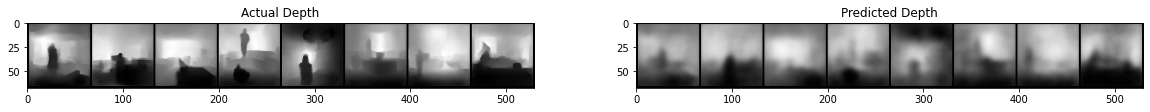

In [35]:
show_images(test_depth,test_predDepth,title='Depth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


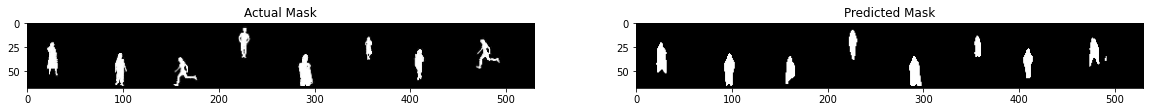

In [36]:
show_images(test_mask,test_predMask,title='Mask')